DATA INGESTION

In [2]:
import ffmpeg
import os
import whisper
import pyannote.audio  # For speaker diarization
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd


In [3]:
def extract_audio_from_video(video_path, audio_path):
    """
    Extract audio from video and save it as a separate file using FFmpeg.
    """
    ffmpeg.input(video_path).output(audio_path).run()
    return audio_path


In [4]:
def convert_audio_to_wav(file_path, output_path):
    """
    Convert audio file to WAV format using FFmpeg.
    """
    ffmpeg.input(file_path).output(output_path).run()
    return output_path


In [5]:
def load_file(file_path):
    """
    Load and handle audio or video files.
    """
    file_ext = os.path.splitext(file_path)[1].lower()
    
    if file_ext in ['.mp3', '.wav']:
        if file_ext != '.wav':
            audio_path = file_path.replace(file_ext, '.wav')
            convert_audio_to_wav(file_path, audio_path)
            return audio_path
        return file_path
    
    elif file_ext == '.mp4':
        audio_path = file_path.replace('.mp4', '.wav')
        extract_audio_from_video(file_path, audio_path)
        return audio_path
    
    else:
        raise ValueError("Unsupported file format")


In [ ]:
# import subprocess

# def extract_audio_from_video(video_path, audio_path):
#     """
#     Extract audio from a video file using the ffmpeg command-line tool.
    
#     Arguments:
#     video_path -- path to the video file.
#     audio_path -- path where the audio file will be saved.
#     """
#     command = [
#         'ffmpeg',
#         '-i', video_path,
#         '-q:a', '0',
#         '-map', 'a',
#         audio_path
#     ]
#     subprocess.run(command, check=True)


In [6]:
# Specify the file path
file_path = 'videoplayback.mp4'  # Update with your file path

# Load and process the file
audio_path = load_file(file_path)

print(f"Processed audio file saved at: {audio_path}")


Processed audio file saved at: videoplayback.wav


TRANSCRIPTION

In [7]:
def transcribe_audio(audio_path):
    """
    Transcribe audio file using OpenAI's Whisper model.
    """
    model = whisper.load_model("base")  # You can choose a different model size if needed
    
    # Perform transcription
    result = model.transcribe(audio_path)
    
    return result['text']

transcription = transcribe_audio(audio_path)

print("Transcription:")
print(transcription)

Transcription:
 Good morning. Oh, hello, good morning. Can I help you? Yes, you can. Actually, I'm looking for a present for my brother. Right, for your brother. Yes. What about a t-shirt? No, not a t-shirt. No. How about a denim jacket? Oh, yes. Actually, that's lovely. I like that. What size does he take? He takes a small. Okay. How about this? Great. That's lovely. I'll take that one. It's 50 euros. Is there a discount? There is today and it's 40 euros with the discount. Fantastic. I'll take it. Super. Thank you. Would you like it gift wrapped? No, thank you. I would like to do it myself. Okay. So with the discount, that's 40 euros. 40 euros? Yes. Here's 50. Thank you. And here's your 10 change. Thank you very much. You're welcome. And then here's your jacket. Thank you. Bye-bye. Bye-bye. Have a good day. Thank you. Bye-bye. Thank you.


TOPIC EXTRACTION

In [132]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import spacy

# Download stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load SpaCy model for advanced NLP
nlp = spacy.load("en_core_web_sm")

# Predefined list of common topics and their associated keywords
predefined_topics = {
    'Product Inquiry': ['product', 'item', 'availability', 'stock', 'details', 'features'],
    'Order Status': ['order', 'status', 'shipment', 'delivery', 'tracking', 'ETA'],
    'Return and Refund': ['return', 'refund', 'exchange', 'policy', 'process', 'refund'],
    'Customer Support': ['support', 'help', 'assistance', 'issue', 'problem', 'service'],
    'Pricing and Discounts': ['price', 'discount', 'offer', 'promotion', 'cost', 'coupon'],
    'Shipping and Handling': ['shipping', 'handling', 'fees', 'charges', 'delivery', 'shipping'],
    'Account Management': ['account', 'login', 'password', 'update', 'information', 'profile'],
    'Feedback and Complaints': ['feedback', 'complaint', 'review', 'suggestion', 'problem', 'issue'],
    'Technical Support': ['technical', 'troubleshooting', 'issue', 'error', 'solution', 'support'],
    'Loyalty Programs': ['loyalty', 'rewards', 'points', 'membership', 'benefits', 'discounts'],
    'In-Store Experience': ['store', 'experience', 'layout', 'staff', 'service', 'environment'],
    'Online Shopping Experience': ['website', 'app', 'checkout', 'navigation', 'user', 'experience'],
    'Payment Issues': ['payment', 'transaction', 'error', 'method', 'credit', 'debit'],
    'Product Availability': ['availability', 'stock', 'backorder', 'preorder', 'in-store'],
    'Special Orders': ['special order', 'customization', 'request', 'order', 'details'],
    'Gift Services': ['gift', 'wrapping', 'card', 'registry', 'gift', 'return'],
    'Subscription Services': ['subscription', 'renewal', 'cancellation', 'plan', 'billing'],
}

def extract_keywords(text, num_keywords=5):
    """
    Extracts the top keywords from the given text using frequency analysis.
    Filters out common stopwords.
    """
    doc = nlp(text.lower())
    words = [token.text for token in doc if token.is_alpha and token.text not in stop_words]
    word_freq = Counter(words)
    most_common_words = word_freq.most_common(num_keywords)
    keywords = [word for word, freq in most_common_words]
    
    return keywords

def extract_topics_sbert(texts, num_clusters=5):
    """
    Extract topics from text using SBERT for embedding and KMeans for clustering.
    Then, extract keywords from each cluster to represent the topics.
    """
    # Load SBERT model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Smaller and faster version of BERT
    
    # Generate sentence embeddings
    embeddings = model.encode(texts, show_progress_bar=True)
    
    # Perform KMeans clustering to group similar sentences
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    labels = kmeans.labels_
    
    # Create a dataframe to map each sentence to its cluster
    df = pd.DataFrame({'text': texts, 'cluster': labels})
    
    # Extract the most representative sentence for each cluster
    topics = {}
    for cluster in range(num_clusters):
        cluster_texts = df[df['cluster'] == cluster]['text'].tolist()
        cluster_text = ' '.join(cluster_texts)
        keywords = extract_keywords(cluster_text, num_keywords=5)
        topics[f'Topic {cluster+1}'] = keywords
    
    return topics

def match_topic(keywords, predefined_topics):
    """
    Match the extracted keywords to predefined topics using TF-IDF and cosine similarity.
    """
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    predefined_topic_texts = {topic: ' '.join(keywords) for topic, keywords in predefined_topics.items()}
    
    tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(keywords) for keywords in predefined_topics.values()] + [' '.join(keywords)])
    cosine_similarities = cosine_similarity(tfidf_matrix[-1:], tfidf_matrix[:-1])
    
    best_topic_idx = np.argmax(cosine_similarities)
    best_topic = list(predefined_topics.keys())[best_topic_idx]
    
    return best_topic

def predict_topics_from_transcription(transcription, predefined_topics, num_clusters=3):
    """
    Predict the topic of the transcription, including matched predefined topics and generated new topics.
    """
    # Split the transcription into sentences
    transcription_sentences = [sentence.strip() for sentence in transcription.split('.') if sentence.strip()]
    
    # Generate topics using SBERT clustering
    topics = extract_topics_sbert(transcription_sentences, num_clusters=num_clusters)
    
    # Print matched predefined topics and generated new topics
    #print("Matched predefined topics and generated new topics:")
    for topic, keywords in topics.items():
        # Match to predefined topics
        predicted_topic = match_topic(keywords, predefined_topics)
        
        if predicted_topic:
            print(f"Topics: {predicted_topic}")
            # generated_topic = ' '.join(keywords)
            # print(f"Generated new topic: {generated_topic}")
        else:
            # If no predefined topic matches, generate a new topic
            generated_topic = ' '.join(keywords)
            print(f"Generated new topic: {generated_topic}")

# Example usage
predict_topics_from_transcription(
    transcription,
    predefined_topics,
    num_clusters=5
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Merlin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Topics: Product Inquiry
Topics: Customer Support
Topics: Product Inquiry
Topics: Pricing and Discounts
Topics: Product Inquiry


In [51]:
pip install langdetect

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     - ------------------------------------- 30.7/981.5 kB 1.3 MB/s eta 0:00:01
     --- ----------------------------------- 92.2/981.5 kB 1.1 MB/s eta 0:00:01
     ------- ------------------------------ 204.8/981.5 kB 1.8 MB/s eta 0:00:01
     ---------- --------------------------- 276.5/981.5 kB 1.7 MB/s eta 0:00:01
     ------------------- ------------------ 491.5/981.5 kB 2.4 MB/s eta 0:00:01
     -------------------- ----------------- 532.5/981.5 kB 2.4 MB/s eta 0:00:01
     ---------------------------- --------- 747.5/981.5 kB 2.6 MB/s eta 0:00:01
     ------------------------------- ------ 819.2/981.5 kB 2.6 MB/s eta 0:00:01
     -------------------------------------  962.6/981.5 kB 2.7 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langd


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install pyAudioAnalysis


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
pip install pydub librosa nltk langdetect


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pydub in c:\users\merlin\appdata\local\programs\python\python311\lib\site-packages (0.25.1)




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


METADATA

In [12]:
import pydub
from pydub import AudioSegment
import librosa
import numpy as np
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import langdetect
import nltk
from pyAudioAnalysis import audioSegmentation as aS

def extract_metadata(audio_path):
    """
    Extract metadata from an audio file including number of speakers, duration of speech per speaker,
    language, number of words spoken, frequency of certain keywords, and additional audio features.
    """
    # Load audio file with pydub
    audio = AudioSegment.from_wav(audio_path)
    duration = len(audio) / 1000.0  # Duration in seconds
    sample_rate = audio.frame_rate
    channels = audio.channels

    # Speaker diarization with a range of possible speakers
    possible_speakers = range(2, 10)  # Adjust range as needed
    best_segments = None
    best_num_speakers = 0

    for n_speakers in possible_speakers:
        try:
            segments, _, _ = aS.speaker_diarization(audio_path, n_speakers=n_speakers)
            if len(segments) > 0:
                best_segments = segments
                best_num_speakers = n_speakers
                break  # If valid segments are found, break the loop
        except Exception as e:
            continue  # Try the next number of speakers

    if best_segments is None:
        raise ValueError("No valid segments were returned from the diarization process.")

    # Determine the number of unique speakers
    unique_speakers = set(best_segments)
    num_speakers = len(unique_speakers)
    
    # Initialize speaker durations
    speaker_durations = defaultdict(float)
    
    if len(best_segments) > 0:
        start_time = 0
        current_speaker = best_segments[0]
        for i in range(1, len(best_segments)):
            if best_segments[i] != current_speaker:
                end_time = i * (duration / len(best_segments))
                speaker_durations[current_speaker] += (end_time - start_time)
                start_time = end_time
                current_speaker = best_segments[i]
        # Handle the last segment
        end_time = duration
        speaker_durations[current_speaker] += (end_time - start_time)
    
    # Transcribe audio using Whisper model
    transcription = transcribe_audio(audio_path)
    
    # Detect language
    try:
        language = langdetect.detect(transcription)
    except langdetect.lang_detect_exception.LangDetectException:
        language = 'unknown'

    # Tokenize and count words
    words = word_tokenize(transcription.lower())
    num_words = len([word for word in words if word.isalpha()])
    
    # Extract keywords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    word_freq = Counter(filtered_words)
    most_common_keywords = word_freq.most_common(10)

    # Load audio using librosa
    y, sr = librosa.load(audio_path, sr=None)

    # Extract additional features using librosa
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
    rms_energy = np.mean(librosa.feature.rms(y=y))
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma_features = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)

    # metadata
    metadata = {
        'duration(secs)': duration,
        'sample_rate': sample_rate,
        'channels': channels,
        'speaker_durations(secs)': {f'Speaker {i+1}': dur for i, dur in enumerate(speaker_durations.values())},
        'number_of_speakers': num_speakers,
        'language': language,
        'num_words': num_words,
        'most_common_keywords': most_common_keywords,
        'tempo': tempo,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'zero_crossing_rate': zero_crossing_rate,
        'rms_energy': rms_energy,
        'mfccs': mfccs.tolist(),  # Convert to list for better readability
        'chroma_features': chroma_features.tolist()  # Convert to list for better readability
    }

    return metadata

# Extract metadata
metadata = extract_metadata(audio_path)

# Print each key-value pair on a new line
for key, value in metadata.items():
    if isinstance(value, (list, dict)):
        print(f"{key}:")
        for sub_key, sub_value in (value.items() if isinstance(value, dict) else enumerate(value)):
            print(f"  {sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


duration(secs): 115.125
sample_rate: 44100
channels: 2
speaker_durations(secs):
  Speaker 1: 50.31092528236316
  Speaker 2: 64.81407471763684
number_of_speakers: 2
language: en
num_words: 142
most_common_keywords:
  0: ('thank', 7)
  1: ('yes', 4)
  2: ('euros', 4)
  3: ('good', 3)
  4: ('like', 3)
  5: ('take', 3)
  6: ('discount', 3)
  7: ('morning', 2)
  8: ('oh', 2)
  9: ('actually', 2)
tempo: 112.34714673913044
spectral_centroid: 2471.5104933993657
spectral_bandwidth: 2288.4962044609924
zero_crossing_rate: 0.07944548148066452
rms_energy: 0.04921536147594452
mfccs:
  0: -323.974853515625
  1: 110.3151626586914
  2: -18.17221450805664
  3: 20.619373321533203
  4: 2.689293146133423
  5: -1.655256986618042
  6: -2.820296049118042
  7: -9.0484619140625
  8: -1.7250150442123413
  9: -10.306529998779297
  10: -3.6855151653289795
  11: -3.7562594413757324
  12: -4.68534517288208
chroma_features:
  0: 0.440629780292511
  1: 0.4300437271595001
  2: 0.4272002577781677
  3: 0.436960905790329


SENTIMENTAL ANALYSIS

In [89]:
pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/626.3 kB 660.6 kB/s eta 0:00:01
   --- ----------------------------------- 61.4/626.3 kB 825.8 kB/s eta 0:00:01
   ----- --------------------------------- 81.9/626.3 kB 657.6 kB/s eta 0:00:01
   ------- ------------------------------ 122.9/626.3 kB 804.6 kB/s eta 0:00:01
   --------- ---------------------------- 163.8/626.3 kB 756.6 kB/s eta 0:00:01
   ------------- ------------------------ 225.3/626.3 kB 860.2 kB/s eta 0:00:01
   ----------------- -------------------- 286.7/626.3 kB 930.9 kB/s eta 0:00:01
   ------------------------ --------------- 389.1/626.3 kB 1.1 MB/s eta 0:00:01
   -------------------------- ------------- 409.6/626.3 kB 1.1 MB/s eta 0:00:01
   -------------------------------- ------- 501.8/626.3 kB 1.2 MB/s eta 0:00:01
   -------------------------------- ------- 501.8/626.3 kB 1.2 MB/s eta 0:00:01
   -------------------------------- ------- 501.8


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


SENTIMENTAL ANALYSIS

In [66]:
# def assign_speaker_segments(transcription):
#     """
#     Assign speaker segments for the given transcription text by alternating between Speaker 1 and Speaker 2.

#     Arguments:
#     transcription -- a string containing the full conversation.

#     Returns:
#     speaker_segments -- a list of speaker numbers (1 or 2) corresponding to each line in the transcription.
#     """
#     # Split the transcription into individual lines
#     lines = [line.strip() for line in transcription.strip().split('\n') if line.strip()]

#     # Alternating between Speaker 1 and Speaker 2
#     speaker_segments = []
#     for i, line in enumerate(lines):
#         if i % 2 == 0:
#             speaker_segments.append(1)  # Speaker 1
#         else:
#             speaker_segments.append(2)  # Speaker 2

#     return speaker_segments

# # Example usage of the function
# transcription = """
# Good morning.
# Oh, hello, good morning.
# Can I help you?
# Yes, you can. Actually, I'm looking for a present for my brother.
# Right, for your brother.
# Yes.
# What about a t-shirt?
# No, not a t-shirt.
# How about a denim jacket?
# Oh, yes. Actually, that's lovely. I like that.
# What size does he take?
# He takes a small.
# Okay. How about this?
# Great. That's lovely. I'll take that one.
# It's 50 euros.
# Is there a discount?
# There is today and it's 40 euros with the discount.
# Fantastic. I'll take it.
# Super. Thank you. Would you like it gift wrapped?
# No, thank you. I would like to do it myself.
# Okay. So with the discount, that's 40 euros.
# 40 euros?
# Yes.
# Here's 50.
# Thank you. And here's your 10 change.
# Thank you very much.
# You're welcome. And then here's your jacket.
# Thank you.
# Bye-bye.
# Bye-bye.
# Have a good day.
# Thank you.
# Bye-bye.
# Thank you.
# """

# # Call the function to assign speaker segments
# speaker_segments = assign_speaker_segments(transcription)

# # Output the speaker segments for each line
# print("Speaker Segments:", speaker_segments)


Speaker Segments: [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


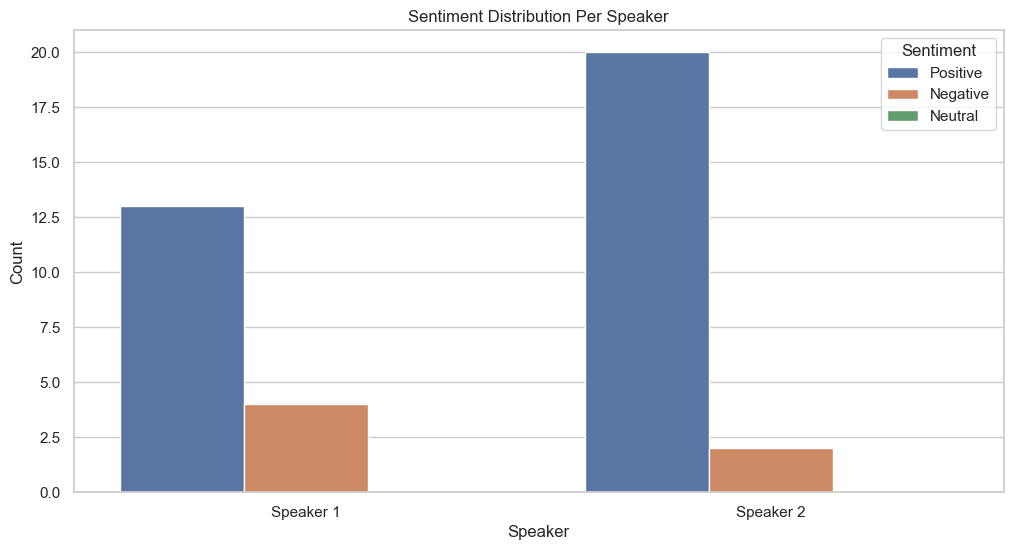

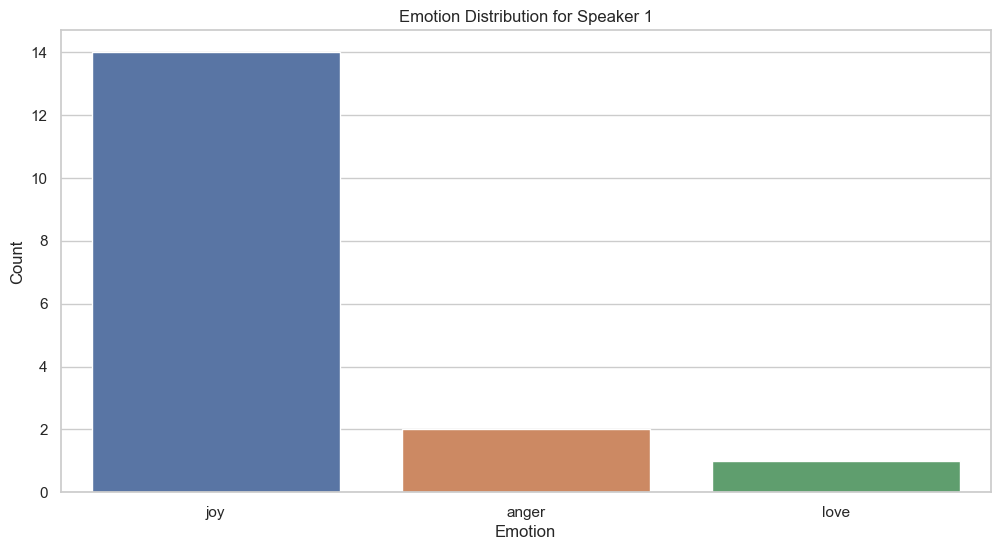

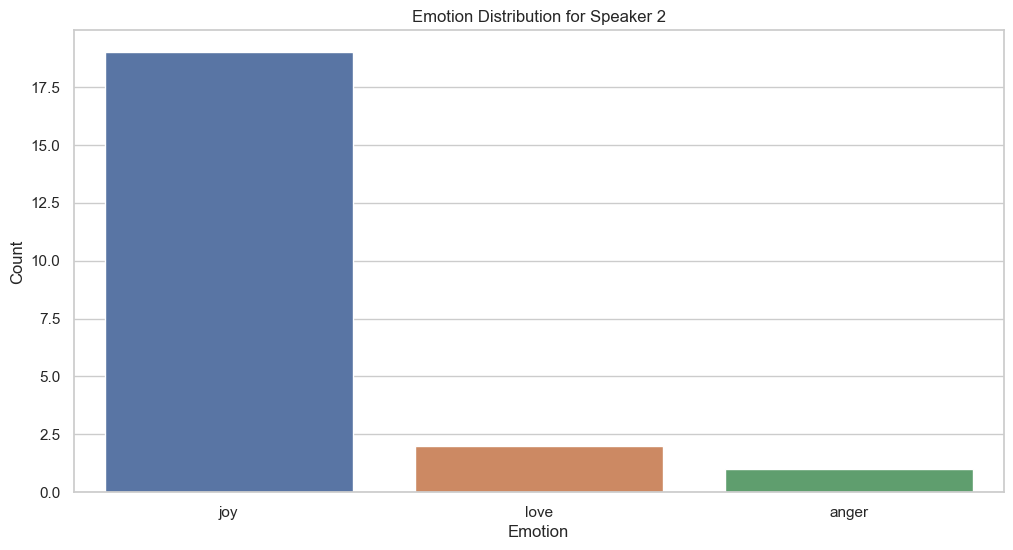

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from collections import defaultdict
import pyAudioAnalysis.audioSegmentation as aS  # Assuming you're using pyAudioAnalysis for speaker diarization

# Load the sentiment and emotion analysis pipelines
sentiment_model = pipeline("sentiment-analysis")
emotion_model = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion")

def assign_speaker_segments(transcription):
    """
    Assign speaker segments for the given transcription text by alternating between Speaker 1 and Speaker 2.

    Arguments:
    transcription -- a string containing the full conversation.

    Returns:
    speaker_segments -- a list of speaker numbers (1 or 2) corresponding to each line in the transcription.
    """
    # Split the transcription into individual lines
    lines = [line.strip() for line in transcription.strip().split('\n') if line.strip()]

    # Alternating between Speaker 1 and Speaker 2
    speaker_segments = []
    for i, line in enumerate(lines):
        if i % 2 == 0:
            speaker_segments.append(1)  # Speaker 1
        else:
            speaker_segments.append(2)  # Speaker 2

    return speaker_segments

def analyze_sentiment_per_speaker(transcription, speaker_segments):
    """
    Perform sentiment analysis on the transcribed text and categorize each speaker's statements
    into positive, negative, or neutral.

    Arguments:
    transcription -- the transcribed text.
    speaker_segments -- list of speaker segments corresponding to the transcription.

    Returns:
    speaker_sentiments -- dictionary with speakers and their corresponding sentiment distributions.
    """
    # Split transcription into sentences
    sentences = [sentence.strip() for sentence in transcription.split('.') if sentence.strip()]

    # Associate each sentence with a speaker based on speaker_segments
    speaker_sentences = defaultdict(list)
    num_sentences = len(sentences)

    # Ensure speaker_segments is at least as long as the number of sentences
    if len(speaker_segments) < num_sentences:
        speaker_segments += [speaker_segments[-1]] * (num_sentences - len(speaker_segments))

    for i, sentence in enumerate(sentences):
        if i < len(speaker_segments):
            speaker = f'Speaker {speaker_segments[i]}'
            speaker_sentences[speaker].append(sentence)

    # Analyze sentiment for each speaker
    speaker_sentiments = defaultdict(list)

    for speaker, sentences in speaker_sentences.items():
        for sentence in sentences:
            if sentence:  # Skip empty sentences
                sentiment_result = sentiment_model(sentence)[0]
                speaker_sentiments[speaker].append(sentiment_result)

    return dict(speaker_sentiments)  # Ensure it's a dictionary

def categorize_sentiments(speaker_sentiments):
    """
    Categorize the sentiments for each speaker into positive, negative, and neutral.
    
    Arguments:
    speaker_sentiments -- dictionary containing sentiment analysis results per speaker.
    
    Returns:
    sentiment_distribution -- dictionary with speakers and their categorized sentiment counts.
    """
    sentiment_distribution = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0})
    
    for speaker, sentiments in speaker_sentiments.items():
        for sentiment in sentiments:
            label = sentiment['label'].lower()  # 'LABEL_0' -> 'negative', 'LABEL_1' -> 'positive'
            if label == 'positive':
                sentiment_distribution[speaker]['positive'] += 1
            elif label == 'negative':
                sentiment_distribution[speaker]['negative'] += 1
            else:
                sentiment_distribution[speaker]['neutral'] += 1
    
    return sentiment_distribution

def analyze_emotion_per_speaker(transcription, speaker_segments):
    """
    Perform emotion analysis on the transcribed text and categorize each speaker's statements
    into different emotions.
    
    Arguments:
    transcription -- the transcribed text.
    speaker_segments -- a list containing the speaker label for each segment of the transcription.
    
    Returns:
    speaker_emotions -- dictionary with speakers and their corresponding emotion distributions.
    """
    # Split transcription into sentences
    sentences = [sentence.strip() for sentence in transcription.split('.') if sentence.strip()]
    
    # Associate each sentence with a speaker based on speaker_segments
    speaker_sentences = defaultdict(list)
    num_sentences = len(sentences)
    
    # Ensure speaker_segments is at least as long as the number of sentences
    if len(speaker_segments) < num_sentences:
        speaker_segments += [speaker_segments[-1]] * (num_sentences - len(speaker_segments))
    
    for i, sentence in enumerate(sentences):
        if i < len(speaker_segments):
            speaker = f'Speaker {speaker_segments[i]}'
            speaker_sentences[speaker].append(sentence)
    
    # Analyze emotion for each speaker
    speaker_emotions = defaultdict(list)
    
    for speaker, sentences in speaker_sentences.items():
        for sentence in sentences:
            if sentence:  # Skip empty sentences
                emotion_result = emotion_model(sentence)[0]
                speaker_emotions[speaker].append(emotion_result)
    
    return dict(speaker_emotions)  # Ensure it's a dictionary

def categorize_emotions(speaker_emotions):
    """
    Categorize the emotions for each speaker into different emotion types.
    
    Arguments:
    speaker_emotions -- dictionary containing emotion analysis results per speaker.
    
    Returns:
    emotion_distribution -- dictionary with speakers and their categorized emotion counts.
    """
    emotion_distribution = defaultdict(lambda: defaultdict(int))
    
    for speaker, emotions in speaker_emotions.items():
        for emotion in emotions:
            label = emotion['label']  # Example: 'joy', 'sadness', 'anger', etc.
            emotion_distribution[speaker][label] += 1
    
    return emotion_distribution

def visualize_sentiment_distribution(sentiment_distribution):
    """
    Visualize the sentiment distribution per speaker using bar plots.
    
    Arguments:
    sentiment_distribution -- dictionary with sentiment counts per speaker.
    """
    # Prepare data for visualization
    data = []
    for speaker, sentiments in sentiment_distribution.items():
        for sentiment, count in sentiments.items():
            data.append({'Speaker': speaker, 'Sentiment': sentiment.capitalize(), 'Count': count})
    
    df = pd.DataFrame(data)
    
    # Create a bar plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Speaker', y='Count', hue='Sentiment', data=df)
    plt.title('Sentiment Distribution Per Speaker')
    plt.xlabel('Speaker')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.show()

def visualize_emotion_distribution(emotion_distribution):
    """
    Visualize the emotion distribution per speaker using separate plots.
    
    Arguments:
    emotion_distribution -- dictionary with emotion counts per speaker.
    """
    for speaker, emotions in emotion_distribution.items():
        # Prepare data for visualization
        data = [{'Emotion': emotion, 'Count': count} for emotion, count in emotions.items()]
        df = pd.DataFrame(data)
        
        # Create a bar plot
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Emotion', y='Count', data=df)
        plt.title(f'Emotion Distribution for {speaker}')
        plt.xlabel('Emotion')
        plt.ylabel('Count')
        plt.show()

# Example transcription
# transcription = """
# Good morning.
# Oh, hello, good morning.
# Can I help you?
# Yes, you can. Actually, I'm looking for a present for my brother.
# Right, for your brother.
# Yes.
# What about a t-shirt?
# No, not a t-shirt.
# How about a denim jacket?
# Oh, yes. Actually, that's lovely. I like that.
# What size does he take?
# He takes a small.
# Okay. How about this?
# Great. That's lovely. I'll take that one.
# It's 50 euros.
# Is there a discount?
# There is today and it's 40 euros with the discount.
# Fantastic. I'll take it.
# Super. Thank you. Would you like it gift wrapped?
# No, thank you. I would like to do it myself.
# Okay. So with the discount, that's 40 euros.
# 40 euros?
# Yes.
# Here's 50.
# Thank you. And here's your 10 change.
# Thank you very much.
# You're welcome. And then here's your jacket.
# Thank you.
# Bye-bye.
# Bye-bye.
# Have a good day.
# Thank you.
# Bye-bye.
# Thank you.
# """

transcription = transcribe_audio(audio_path)

# Assign speaker segments
speaker_segments = assign_speaker_segments(transcription)

# Analyze sentiment
speaker_sentiments = analyze_sentiment_per_speaker(transcription, speaker_segments)

# Categorize the sentiments as positive, negative, or neutral
sentiment_distribution = categorize_sentiments(speaker_sentiments)

# Visualize the sentiment distribution
visualize_sentiment_distribution(sentiment_distribution)

# Analyze emotions
speaker_emotions = analyze_emotion_per_speaker(transcription, speaker_segments)

# Categorize the emotions
emotion_distribution = categorize_emotions(speaker_emotions)

# Visualize the emotion distribution
visualize_emotion_distribution(emotion_distribution)


INSIGHT GENERATION

In [74]:
import pandas as pd
from collections import defaultdict

# Example common complaints list (can be updated dynamically or expanded)
common_complaints_list = [
    "delivery", "customer service", "refund", "pricing", "product quality", 
    "warranty", "out of stock", "return policy", "payment issues", 
    "shipping delay", "damaged goods", "order tracking", "incorrect order", 
    "product availability", "exchange policy", "discount issues", 
    "loyalty program", "billing problems", "size or fit issues", 
    "packaging issues", "communication delay"
]

def detect_conversation_type(num_speakers):
    """
    Determine if the transcription is a panel discussion or a customer-agent conversation.
    
    Arguments:
    num_speakers -- the number of speakers in the transcription
    
    Returns:
    type -- 'panel_discussion' or 'customer_agent_conversation'
    """
    if num_speakers == 2:
        return "customer_agent_conversation"
    elif num_speakers > 2:
        return "panel_discussion"
    else:
        return "unknown"

def calculate_customer_satisfaction(sentiment_distribution):
    """
    Calculate the customer satisfaction score based on sentiment distribution.
    
    Arguments:
    sentiment_distribution -- dictionary with sentiment counts per speaker
    
    Returns:
    satisfaction_score -- customer satisfaction score as a percentage
    """
    total_positive = sum(s['positive'] for s in sentiment_distribution.values())
    total_negative = sum(s['negative'] for s in sentiment_distribution.values())
    total_sentiments = total_positive + total_negative
    
    if total_sentiments == 0:
        return 0
    
    satisfaction_score = (total_positive / total_sentiments) * 100
    return satisfaction_score

def generate_suggestions(sentiment_distribution):
    """
    Generate suggestions based on sentiment distribution.
    
    Arguments:
    sentiment_distribution -- dictionary with sentiment counts per speaker
    
    Returns:
    suggestions -- list of suggestions based on sentiment distribution
    """
    positive_sentiments = sum(s['positive'] for s in sentiment_distribution.values())
    negative_sentiments = sum(s['negative'] for s in sentiment_distribution.values())
    
    suggestions = []
    if positive_sentiments > negative_sentiments:
        suggestions.append("Continue to provide excellent service and consider additional perks for loyal customers.")
    if negative_sentiments > positive_sentiments:
        suggestions.append("Address any negative feedback promptly and work on improving the customer experience.")
    if positive_sentiments == 0 and negative_sentiments == 0:
        suggestions.append("Maintain current service standards but explore areas for potential enhancement.")
    
    return suggestions

def generate_improvement_suggestions(satisfaction_score):
    """
    Generate additional suggestions if the customer satisfaction score is below 50%.
    
    Arguments:
    satisfaction_score -- customer satisfaction score as a percentage
    
    Returns:
    improvement_suggestions -- list of improvement suggestions
    """
    improvement_suggestions = []
    if satisfaction_score < 50:
        improvement_suggestions.append("Implement customer feedback mechanisms to identify specific areas for improvement.")
        improvement_suggestions.append("Enhance training for customer service representatives to better handle customer issues.")
        improvement_suggestions.append("Review and streamline complaint resolution processes to reduce response times.")
        improvement_suggestions.append("Consider offering compensatory measures, such as discounts or incentives, to dissatisfied customers.")
    
    return improvement_suggestions

def capture_complaints(transcription):
    """
    Capture complaints from the transcription based on common complaint keywords.
    
    Arguments:
    transcription -- the transcribed text from Whisper
    
    Returns:
    complaints -- list of complaints identified in the transcription
    """
    complaints = []
    sentences = [sentence.strip() for sentence in transcription.split('.') if sentence.strip()]
    
    for sentence in sentences:
        for keyword in common_complaints_list:
            if keyword in sentence.lower():
                complaints.append(sentence)
                break  # Once a keyword is matched, no need to check other keywords for this sentence
    
    return complaints

# Example transcription for testing
# transcription = " Good morning. Oh, hello, good morning. Can I help you? Yes, you can. Actually, I'm looking for a present for my brother. Right, for your brother. Yes. What about a t-shirt? No, not a t-shirt. No. How about a denim jacket? Oh, yes. Actually, that's lovely. I like that. What size does he take? He takes a small. Okay. How about this? Great. That's lovely. I'll take that one. It's 50 euros. Is there a discount? There is today and it's 40 euros with the discount. Fantastic. I'll take it. Super. Thank you. Would you like it gift wrapped? No, thank you. I would like to do it myself. Okay. So with the discount, that's 40 euros. 40 euros? Yes. Here's 50. Thank you. And here's your 10 change. Thank you very much. You're welcome. And then here's your jacket. Thank you. Bye-bye. Bye-bye. Have a good day. Thank you. Bye-bye. Thank you"

transcription = transcribe_audio(audio_path)

# Determine the number of speakers based on the sentiment distribution dictionary
num_speakers = len(sentiment_distribution)

# Detect the conversation type
conversation_type = detect_conversation_type(num_speakers)
print(f"Conversation Type: {conversation_type}")

# Capture complaints
complaints = capture_complaints(transcription)
if complaints:
    print("Complaints:")
    for complaint in complaints:
        print(f"- {complaint}")
else:
    print("No complaints!! Everything is Good.")

# Calculate customer satisfaction score (only applicable for customer-agent conversations)
if conversation_type == "customer_agent_conversation":
    satisfaction_score = calculate_customer_satisfaction(sentiment_distribution)
    print(f"Customer Satisfaction Score: {satisfaction_score:.2f}%")

    # Generate suggestions based on sentiment distribution
    suggestions = generate_suggestions(sentiment_distribution)
    print("Suggestions:")
    for suggestion in suggestions:
        print(f"- {suggestion}")

    # Generate additional suggestions if satisfaction score is below 50%
    improvement_suggestions = generate_improvement_suggestions(satisfaction_score)
    if improvement_suggestions:
        print("Additional Improvement Suggestions:")
        for suggestion in improvement_suggestions:
            print(f"- {suggestion}")
else:
    print("Suggestions are only applicable for customer-agent conversations.")


Conversation Type: customer_agent_conversation
No complaints!! Everything is Good.
Customer Satisfaction Score: 84.62%
Suggestions:
- Continue to provide excellent service and consider additional perks for loyal customers.


LLM

In [110]:
from transformers import pipeline

# Load the Pegasus summarization model
summarizer = pipeline("summarization", model="google/pegasus-xsum")

def generate_summary(transcription):
    """
    Generate a summary of the transcription using Pegasus.
    
    Arguments:
    transcription -- the transcribed text.
    
    Returns:
    summary -- the summary of the transcription.
    """
    summary = summarizer(transcription, max_length=150, min_length=30, do_sample = False, temperature=0.7, top_p=0.9, repetition_penalty=1.2)
    return summary[0]['summary_text']

# Example transcription
# transcription = """
# Good morning. Oh, hello, good morning. Can I help you? Yes, you can. Actually, I'm looking for a present for my brother. 
# Right, for your brother. Yes. What about a t-shirt? No, not a t-shirt. How about a denim jacket? Oh, yes. Actually, that's lovely. 
# I like that. What size does he take? He takes a small. Okay. How about this? Great. That's lovely. I'll take that one. It's 50 euros. 
# Is there a discount? There is today and it's 40 euros with the discount. Fantastic. I'll take it. Super. Thank you. Would you like it gift wrapped? 
# No, thank you. I would like to do it myself. Okay. So with the discount, that's 40 euros. 40 euros? Yes. Here's 50. 
# Thank you. And here's your 10 change. Thank you very much. You're welcome. And then here's your jacket. Thank you. Bye-bye. 
# Bye-bye. Have a good day. Thank you. Bye-bye. Thank you.
# """

transcription = transcribe_audio(audio_path)

# Generate summary
summary = generate_summary(transcription)
print("\nSummary:", summary)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Summary: The following is a transcript of the phone call between a woman and a man who are trying to buy a present for their brother. Actually, I'm looking for a present for my brother. So with the discount, that's 40 euros.


In [112]:
from transformers import pipeline

# Load the question-answering model
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

def answer_question(context, question):
    """
    Answer a question about the context using a QA model.
    
    Arguments:
    context -- the text of the transcription.
    question -- the question to be answered.
    
    Returns:
    answer -- the answer to the question.
    """
    result = qa_pipeline(question=question, context=context)
    return result['answer']

# Example transcription
# transcription = """
# Good morning. Oh, hello, good morning. Can I help you? Yes, you can. Actually, I'm looking for a present for my brother. 
# Right, for your brother. Yes. What about a t-shirt? No, not a t-shirt. How about a denim jacket? Oh, yes. Actually, that's lovely. 
# I like that. What size does he take? He takes a small. Okay. How about this? Great. That's lovely. I'll take that one. It's 50 euros. 
# Is there a discount? There is today and it's 40 euros with the discount. Fantastic. I'll take it. Super. Thank you. Would you like it gift wrapped? 
# No, thank you. I would like to do it myself. Okay. So with the discount, that's 40 euros. 40 euros? Yes. Here's 50. 
# Thank you. And here's your 10 change. Thank you very much. You're welcome. And then here's your jacket. Thank you. Bye-bye. 
# Bye-bye. Have a good day. Thank you. Bye-bye. Thank you.
# """

transcription = transcribe_audio(audio_path)

# Get the question from the user
#question = "for whom the jacket is brought for?"
question = input("Please enter your question: ")

# Answer the question
answer = answer_question(transcription, question)
print("Answer:", answer)


Answer: my brother


In [124]:
from transformers import pipeline, MarianMTModel, MarianTokenizer
import pandas as pd

# Load models
sentiment_analyzer = pipeline("sentiment-analysis")
intent_recognizer = pipeline("zero-shot-classification")
translation_model_name = "Helsinki-NLP/opus-mt-en-de"  # English to German
translation_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)
translation_model = MarianMTModel.from_pretrained(translation_model_name)

def analyze_sentiment(text):
    """
    Analyze the sentiment of the text.
    
    Arguments:
    text -- the input text.
    
    Returns:
    sentiment_label -- the sentiment label (e.g., POSITIVE, NEGATIVE).
    sentiment_score -- the sentiment score.
    """
    result = sentiment_analyzer(text)
    return result[0]['label'], result[0]['score']

def recognize_intent(text, candidate_labels):
    """
    Recognize the intent of the text using zero-shot classification.
    
    Arguments:
    text -- the input text.
    candidate_labels -- list of possible intents.
    
    Returns:
    intent -- the recognized intent.
    """
    result = intent_recognizer(text, candidate_labels=candidate_labels)
    return result['labels'][0], result['scores'][0]

def translate_text(text, src_lang="en", tgt_lang="de"):
    """
    Translate the text using MarianMT model.
    
    Arguments:
    text -- the input text.
    src_lang -- source language code.
    tgt_lang -- target language code.
    
    Returns:
    translated_text -- the translated text.
    """
    inputs = translation_tokenizer.encode(text, return_tensors="pt")
    translated = translation_model.generate(inputs, max_length=100)
    translated_text = translation_tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

def generate_report(sentiment_label, sentiment_score, intent, translated_text):
    """
    Generate a report based on the analysis.
    
    Arguments:
    sentiment_label -- the sentiment label.
    sentiment_score -- the sentiment score.
    intent -- the recognized intent.
    facts -- list of extracted facts.
    translated_text -- the translated text.
    
    Returns:
    report -- the generated report.
    """
    report = {
        "Sentiment Label": sentiment_label,
        "Sentiment Score": sentiment_score,
        "Intent": intent,
        "Translated Text": translated_text
    }
    return report

# Example usage
# transcription = """
# Good morning. Oh, hello, good morning. Can I help you? Yes, you can. Actually, I'm looking for a present for my brother. 
# Right, for your brother. Yes. What about a t-shirt? No, not a t-shirt. How about a denim jacket? Oh, yes. Actually, that's lovely. 
# I like that. What size does he take? He takes a small. Okay. How about this? Great. That's lovely. I'll take that one. It's 50 euros. 
# Is there a discount? There is today and it's 40 euros with the discount. Fantastic. I'll take it. Super. Thank you. Would you like it gift wrapped? 
# No, thank you. I would like to do it myself. Okay. So with the discount, that's 40 euros. 40 euros? Yes. Here's 50. 
# Thank you. And here's your 10 change. Thank you very much. You're welcome. And then here's your jacket. Thank you. Bye-bye. 
# Bye-bye. Have a good day. Thank you. Bye-bye. Thank you.
# """

transcription = transcribe_audio(audio_path)

# Perform analyses
sentiment_label, sentiment_score = analyze_sentiment(transcription)
intent, intent_score = recognize_intent(transcription, ["complaint", "inquiry", "request", "feedback"])
translated_text = translate_text(transcription)

# Generate and print report
report = generate_report(sentiment_label, sentiment_score, intent, translated_text)
report_df = pd.DataFrame([report])
print("\n")
print(report_df)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.




  Sentiment Label  Sentiment Score   Intent  \
0        POSITIVE         0.999653  inquiry   

                                     Translated Text  
0  Guten Morgen. Oh, hallo, guten Morgen. Kann ic...  
